In [1]:
%matplotlib inline

import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from lmu import LMU, LMUCell

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import to_categorical

In [2]:
# Set seed to ensure this example is reproducible
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

# load mnist dataset
(
    (train_images, train_labels),
    (test_images, test_labels),
) = tf.keras.datasets.mnist.load_data()

# Change inputs to 0--1 range
train_images = train_images / 255
test_images = test_images / 255

# Flatten images into sequences
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# Apply permutation
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

X_train = train_images[0:50000]
X_valid = train_images[50000:]
X_test = test_images

Y_train = train_labels[0:50000]
Y_valid = train_labels[50000:]
Y_test = test_labels

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(50000, 784, 1) (50000,)
(10000, 784, 1) (10000,)
(10000, 784, 1) (10000,)


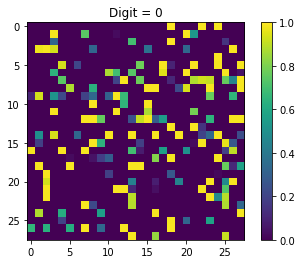

In [3]:
plt.subplot(111)
plt.title("Digit = %d" % Y_train[1])
plt.imshow(X_train[1].reshape(28, 28))
plt.colorbar()
plt.show()

In [7]:
padded_length = 28 ** 2 + 1
n_pixels = padded_length - 1


def lmu_layer(**kwargs):
    return LMU(
            units=212,
            order=256,
            theta=n_pixels,
            input_encoders_initializer=Constant(1),
            hidden_encoders_initializer=Constant(0),
            memory_encoders_initializer=Constant(0),
            input_kernel_initializer=Constant(0),
            hidden_kernel_initializer=Constant(0),
            memory_kernel_initializer="glorot_normal",
            **kwargs
    )


model = Sequential()
model.add(lmu_layer(input_shape=X_train.shape[1:],))  # (nr. of pixels, 1)
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

RNN layer
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lmu_1 (LMU)                  (None, 212)               165689    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2130      
Total params: 167,819
Trainable params: 102,027
Non-trainable params: 65,792
_________________________________________________________________


In [8]:
batch_size = 100
epochs = 10
t = time.time()

fname = "./psMNIST-standard.hdf5"
callbacks = [
    ModelCheckpoint(filepath=fname, monitor="val_loss", verbose=1, save_best_only=True),
]

result = model.fit(
    X_train,
    to_categorical(Y_train),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, to_categorical(Y_valid)),
    callbacks=callbacks,
)

print("Took {:.2f} min".format((time.time() - t) / 60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
49900/50000 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.8650
Epoch 00001: val_loss improved from inf to 0.28646, saving model to ./psMNIST-standard.hdf5
50000/50000 [==============================] - 275s 5ms/sample - loss: 0.4550 - accuracy: 0.8651 - val_loss: 0.2865 - val_accuracy: 0.9144
Epoch 2/10
49900/50000 [============================>.] - ETA: 0s - loss: 0.2620 - accuracy: 0.9215
Epoch 00002: val_loss improved from 0.28646 to 0.19327, saving model to ./psMNIST-standard.hdf5
50000/50000 [==============================] - 274s 5ms/sample - loss: 0.2622 - accuracy: 0.9215 - val_loss: 0.1933 - val_accuracy: 0.9442
Epoch 3/10
49900/50000 [============================>.] - ETA: 0s - loss: 0.1806 - accuracy: 0.9450
Epoch 00003: val_loss improved from 0.19327 to 0.14903, saving model to ./psMNIST-standard.hdf5
50000/50000 [==============================] - 270s 5ms/sample - loss: 0.1807 - accuracy

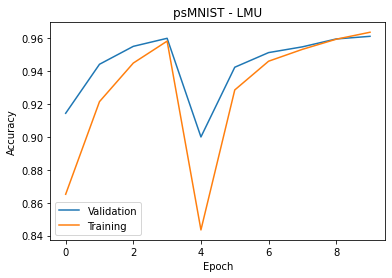

In [9]:
plt.figure()
plt.plot(result.history["val_accuracy"], label="Validation")
plt.plot(result.history["accuracy"], label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("psMNIST - LMU")
plt.show()

In [10]:
saved_epoch = np.argmin(result.history["val_loss"])
print(result.history["val_accuracy"][saved_epoch])

0.9612


In [11]:
model.load_weights(fname)  # load best weights

In [12]:
model.evaluate(X_test, to_categorical(Y_test))

10000/10000 [==============================] - 43s 4ms/sample - loss: 0.1352 - accuracy: 0.9587


[0.13518213040307164, 0.9587]